# Turn and Stop Sign Classification using NN

- Author: Yiran Jing
- Date: 2 Oct 2020
- Version: 2 (try 5 classes and achieve model goal)

Our model can classify the input images (collected by the donkey car) into 5 classes: Right-turning, Left-turning, Park, Stop and other (Other means no sign detected).

### Model Goal
1. Achieve high accuracy overall classes
2. Low misclassification cost: If the model cannot detect the sign correctly, then classified to “other”(i.e. no action).



## Content 
1. **EDA**
2. **Feature Engineering**
    1. Configure the dataset for performance
    2. Standardize the data
3. **Train model**
    1. 20% as test data, 80% as train data
    2. three convolution blocks
4. **Model evaluation**
    1. Confusion Matrix
    2. Classification report for each class
       - The overall TEST accuracy is more than 90%
       - The model performance very well in right, stop, and other, but lower accurate predictions in left, and park.
       - The misclassification of `left` nad `park` mainly classifed into `other`, which is what we expected: if the model cannot detect the sign, then classified to `Other`.
       - Also, it is highly likely that our model is `overfiting`, since evaluate accuracy is near 1, and test arruracy is relatively low. 

       

5. Appendix 1: Adjusting overfit by Dropout, augmented images, and recrease epochs
    - Not useful currently
6. Appendix 2: Visualization data augmented examples

***
### Dataset description
The data within folder `signed_map_test_2Oct`, and the data was collectted by donkey car simulator given by different drivers

- Train data: (6653)
     - There are 731 colored stop turn images.
     - There are 2348 colored other turn images.
     - There are 1328 colored left turn images.
     - There are 1233 colored right turn images.
     - There are 1013 colored park turn images.
     - The total number of turning images are 6653
     
- Test data: (1202)
     - There are 132 colored stop turn images.
     - There are 551 colored other turn images.
     - There are 144 colored left turn images.
     - There are 183 colored right turn images.
     - There are 192 colored park turn images.
- Within the train data, we separate 20% data as the validation data to validate the hyper-parameter turning and avoid overfitting. 
***


### Limitation of CNN model

1. No data cleaning and feature engineering in the image pre-processing
    - Will try to add them to improve mode performance further.
2. Dataset limitation
   - The current dataset is collected based on one map. We will add more kinds of maps' data in the next few weeks.
3. Need advanced hyper-parameter turning technique.
   - The CNN hyper-parameter turning currently just focus on the number of layers, the number of epochs, will try more advanced techniques in the next few weeks.


   
### Benefits of current CNN model

1. Our current CNN model has simple structure
2. The model training is fast (around 10 mins using CPU)
3. Can get real-time prediction with no delay, and thus, the car can take action immediately after detected the sign. 

In [1]:
import matplotlib.pyplot as plt
from os import listdir, rename, listdir
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

/Users/yiranjing/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load dataset and visualization

In [3]:
foler = "signed_map_test_2Oct"

In [4]:
print("Train data: \n")
path = foler+"/train/stop"
stop_image_count = len(listdir(path))
print("There are {} colored stop turn images.".format(stop_image_count))
path = foler+"/train/other"
other_image_count = len(listdir(path))
print("There are {} colored other turn images.".format(other_image_count))
path = foler+"/train/left"
left_image_count = len(listdir(path))
print("There are {} colored left turn images.".format(left_image_count))
path = foler+"/train/right"
right_image_count = len(listdir(path))
print("There are {} colored right turn images.".format(right_image_count))
path = foler+"/train/park"
park_image_count = len(listdir(path))
print("There are {} colored park turn images.".format(park_image_count))
data_dir = pathlib.Path(foler+"/train")
#image_count = len(list(data_dir.glob('*/*.png')))
image_count = len(list(data_dir.glob('*/*'))) # there are some png, also some jpg
print("The total number of turning images are {} ".format(image_count))

Train data: 

There are 731 colored stop turn images.
There are 2348 colored other turn images.
There are 1328 colored left turn images.
There are 1233 colored right turn images.
There are 1013 colored park turn images.
The total number of turning images are 6653 


In [5]:
print("Test data: \n")
path = foler+"/test/stop"
stop_image_count = len(listdir(path))
print("There are {} colored stop turn images.".format(stop_image_count))
path = foler+"/test/other"
other_image_count = len(listdir(path))
print("There are {} colored other turn images.".format(other_image_count))
path = foler+"/test/left"
left_image_count = len(listdir(path))
print("There are {} colored left turn images.".format(left_image_count))
path = foler+"/test/right"
right_image_count = len(listdir(path))
print("There are {} colored right turn images.".format(right_image_count))
path = foler+"/test/park"
park_image_count = len(listdir(path))
print("There are {} colored park turn images.".format(park_image_count))
test_data_dir = pathlib.Path(foler+"/test")
#image_count = len(list(data_dir.glob('*/*.png')))
image_count = len(list(test_data_dir.glob('*/*'))) # there are some png, also some jpg
print("The total number of test images are {} ".format(image_count))

Test data: 

There are 132 colored stop turn images.
There are 551 colored other turn images.
There are 144 colored left turn images.
There are 183 colored right turn images.
There are 192 colored park turn images.
The total number of test images are 1202 


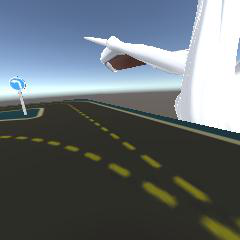

In [6]:
left = list(data_dir.glob('left/*')) # train data
PIL.Image.open(str(left[0]))

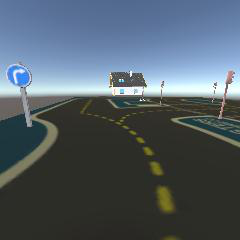

In [7]:
right = list(data_dir.glob('right/*'))
PIL.Image.open(str(right[0]))

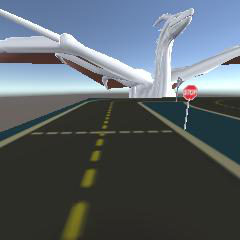

In [8]:
stop = list(data_dir.glob('stop/*'))
PIL.Image.open(str(stop[0]))

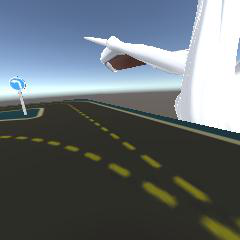

In [9]:
other = list(data_dir.glob('left/*'))
PIL.Image.open(str(other[0]))

In [10]:
# Predefined Hyper-parameter 
learning_rate = 0.001
batch_size = 32
img_height = 240
img_width = 240

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 20% as validation data
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6648 files belonging to 5 classes.
Using 5319 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6648 files belonging to 5 classes.
Using 1329 files for validation.


In [13]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir, 
  image_size=(img_height, img_width),
  seed=123, 
  batch_size=batch_size)

Found 1198 files belonging to 5 classes.


In [14]:
class_names = train_ds.class_names
print(class_names) 

['left', 'other', 'park', 'right', 'stop']


#### Visualization training data

before we train the model, let's firstly, visualize some training data

From image below, we can see that 

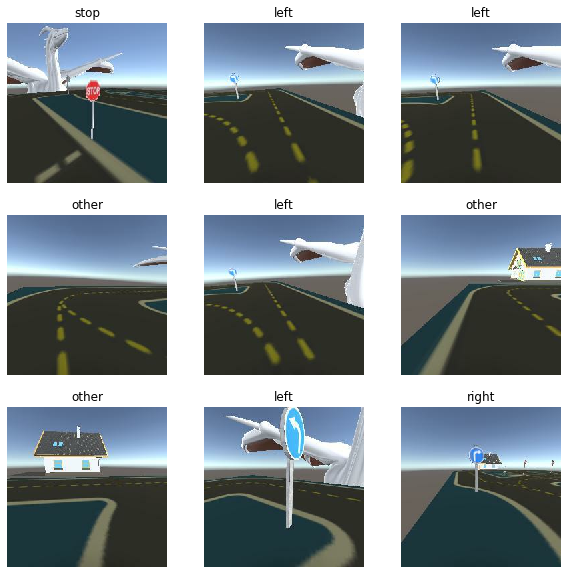

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 240, 240, 3)
(32,)


### Feature Engineering
1. Configure the dataset for performance
2. Standardize the data


#### Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. 

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Standardize the data
The RGB channel values are in the `[0, 255]` range. 
We standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


### Train Model

The model consists of three `convolution blocks` with a `max pool layer` in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, just randomly selected

`relu = max(0, x)`. 

In [20]:
def train_Visualize_CNN(model, 
                        epochs,
                        train_ds, val_ds):
            
    # model compile
    # using Adam optimizer
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
            
        
    print(model.summary())
    
    #train model     
    cnn_history = model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs
        )
    
    return cnn_history

In [36]:
num_classes = 5
epochs = 7
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2) ## add EarlyStopping
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

cnn_1 = Sequential([
          #data_augmentation,
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
          layers.Conv2D(16, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          #layers.Dropout(drop_out), # drop out rate
          layers.Flatten(),
          layers.Dense(128, activation='relu'), 
          layers.Dense(num_classes)
            ])

cnn_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cnn_history_1 = cnn_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=[callback] # EarlyStopping
)

Epoch 1/7
167/167 [==============================] - 184s 1s/step - loss: 0.3900 - accuracy: 0.8547 - val_loss: 0.0982 - val_accuracy: 0.9691
Epoch 2/7
167/167 [==============================] - 215s 1s/step - loss: 0.0379 - accuracy: 0.9891 - val_loss: 0.0197 - val_accuracy: 0.9962
Epoch 3/7
167/167 [==============================] - 157s 940ms/step - loss: 0.0114 - accuracy: 0.9968 - val_loss: 0.0438 - val_accuracy: 0.9895
Epoch 4/7
167/167 [==============================] - 165s 991ms/step - loss: 0.0103 - accuracy: 0.9983 - val_loss: 0.0437 - val_accuracy: 0.9902
Epoch 5/7
167/167 [==============================] - 163s 973ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.0210 - val_accuracy: 0.9925
Epoch 6/7
167/167 [==============================] - 174s 1s/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.0259 - val_accuracy: 0.9932
Epoch 7/7
167/167 [==============================] - 164s 985ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0206 - val_accuracy: 0

In [37]:
def plot_train_result(model_result, epoch):
    acc = model_result.history['accuracy']
    val_acc = model_result.history['val_accuracy']

    loss=model_result.history['loss']
    val_loss=model_result.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### Visualize results

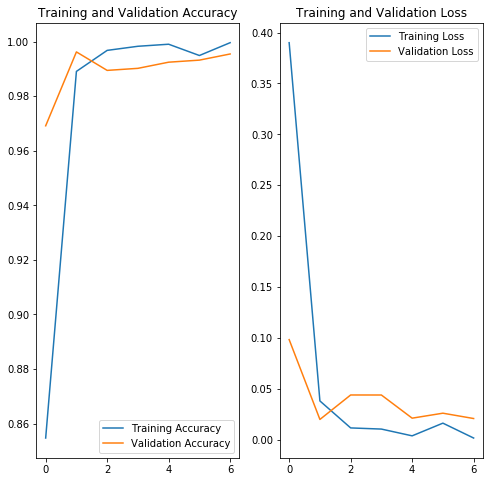

In [38]:
plot_train_result(cnn_history_1, epochs)

From the plot above, we can see that the test accuracy is increasing and then decreasing around epoch = 7. 

## Model evaluation

Reason to add confusion matrix: We select model based on accuracy, but accuracy is just a summary of all classes performance, so to see individual class performance, we should draw confusion matrix. Also, it is good to consider Precision Recall, ROC for each classes.

Based on the test data

### Confusion Matrix

In [39]:
def plot_normalized_confusion_matrix(y_true, y_pred, title, class_names):
    #y_true = np.concatenate([y for x, y in val_ds], axis=0)
    cm = confusion_matrix(y_true, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    target_names = class_names
    fig, ax = plt.subplots(figsize=(8,5))
    fig.suptitle(title,fontsize=20)
    ax.set_xlabel("Preidicted_Label")
    ax.set_ylabel('True_Label')
    plt.xticks(np.arange(0, 60), np.arange(1,60))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, 
            yticklabels=target_names, linewidths=.8,)
    #image_path = 'image/' + model +'_normalized_confusion_matrix.png'
    #fig.savefig(image_path)   
    #plt.close(fig)
    plt.show()  


In [45]:
def draw_confusion_matrix(model, val_ds):
    #Confution Matrix and Classification Report
    Y_pred = model.predict(val_ds)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix, x label is Predicted_Label, y is True_Label')
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    plot_normalized_confusion_matrix(y_true, y_pred, "Normalized Confusion Matrix", class_names) # self-defined function
    
    print('\n\nClassification Report bazed on test data')
    #target_names = train_ds.class_names
    target_names = class_names
    print(classification_report(y_true, y_pred, target_names=target_names))

Confusion Matrix, x label is Predicted_Label, y is True_Label


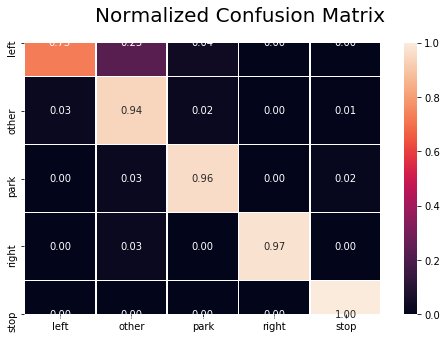



Classification Report bazed on test data
              precision    recall  f1-score   support

        left       0.87      0.73      0.79       143
       other       0.92      0.94      0.93       550
        park       0.91      0.96      0.93       191
       right       1.00      0.97      0.99       183
        stop       0.96      1.00      0.98       131

    accuracy                           0.93      1198
   macro avg       0.93      0.92      0.92      1198
weighted avg       0.93      0.93      0.93      1198



In [46]:
draw_confusion_matrix(cnn_1, test_ds)

- The overall TEST accuracy is more than 90%
- The model performance very well in right, stop, and other, but lower accurate predictions in left, and park.
- The misclassification of `left` nad `park` mainly classifed into `other`, which is what we expected: if the model cannot detect the sign, then classified to `Other`.
- Also, it is highly likely that our model is `overfiting`, since evaluate accuracy is near 1, and test arruracy is relatively low. 

In [43]:
# save model
cnn_1.save('sign_2Oct_nofeatureEngineer.h5')

### Check misclassification images

In [30]:
def draw_missclassification_images(class_name, model, test):

    # test dataset 
    directory = test_data_dir.glob(class_name+'/*.jpg')
    image_list = list(test_data_dir.glob(class_name+'/*.jpg'))
    #test = keras.preprocessing.image_dataset_from_directory(
    #        test_data_dir, image_size=(img_height, img_width),seed=123
    #)
    test = test_ds


    count = 0
    for image in directory:
    
        picture = Image.open(image)
    
        img = keras.preprocessing.image.load_img(
            image, target_size=(img_height, img_width)
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        
        if class_names[np.argmax(score)] != class_name: # miss classification
            print("Image:", str(image).split('/')[-1])
            print("True class: ", class_name)
            print("Predicted class:", class_names[np.argmax(score)], ", with Prediction CI", round(100 * np.max(score), 2))
            
            #draw = ImageDraw.Draw(picture)

            # display image
            pil_im = Image.open(str(image_list[count]), 'r')
            display(pil_im)
            count +=1

            print("\n\n")

Image: 132_cam-image_array_.jpg
True class:  stop
Predicted class: other , with Prediction CI 99.13


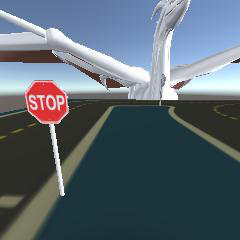




Image: yiran_drive_Oct2_3910.jpg
True class:  stop
Predicted class: other , with Prediction CI 95.64


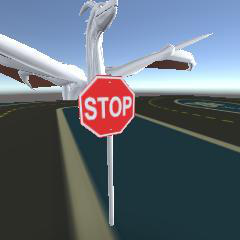

In [31]:
## Misclassification Stop
draw_missclassification_images('stop', cnn_1, test_ds)

Image: 1311_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 100.0


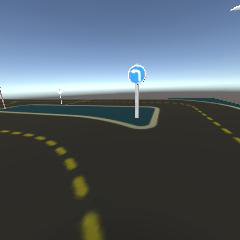




Image: 1314_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.98


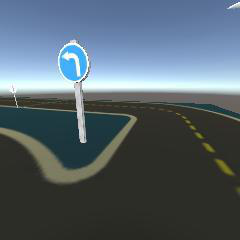




Image: 3494_cam-image_array_ 2.jpg
True class:  left
Predicted class: other , with Prediction CI 100.0


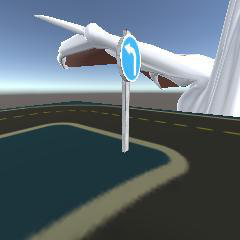




Image: 3616_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 83.95


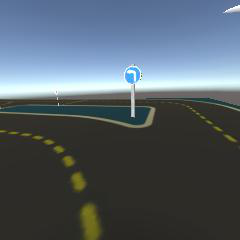




Image: 3492_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.99


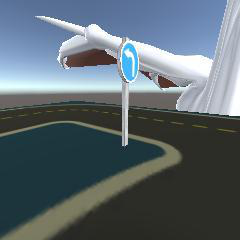




Image: 3501_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 91.1


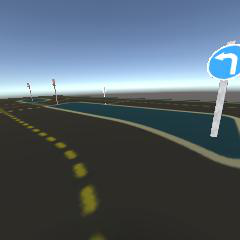




Image: 3497_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.92


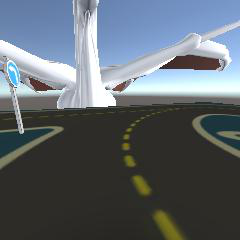




Image: 3493_cam-image_array_ 2.jpg
True class:  left
Predicted class: other , with Prediction CI 99.99


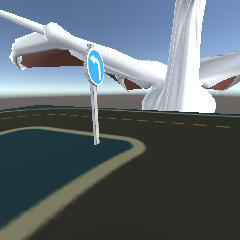




Image: 3498_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 96.73


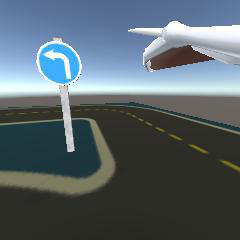




Image: 3621_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.96


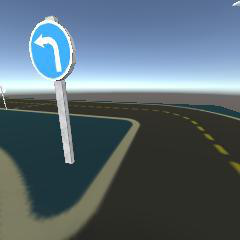




Image: 3619_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 98.38


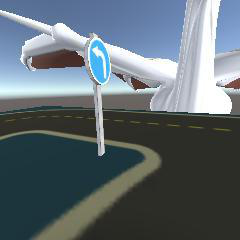




Image: peter_drive_5,967.jpg
True class:  left
Predicted class: park , with Prediction CI 88.72


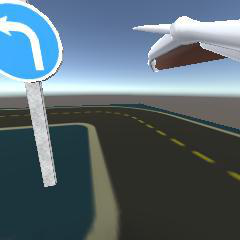




Image: 1310_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 100.0


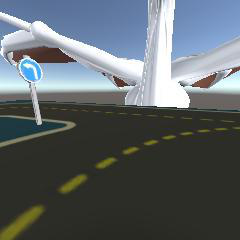




Image: 1315_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.98


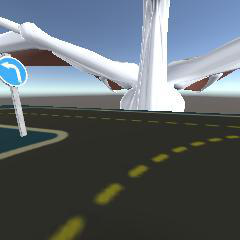




Image: peter_drive_5,970.jpg
True class:  left
Predicted class: park , with Prediction CI 82.47


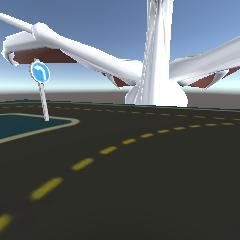




Image: 3495_cam-image_array_ 2.jpg
True class:  left
Predicted class: other , with Prediction CI 100.0


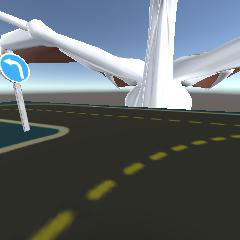




Image: 3499_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 96.73


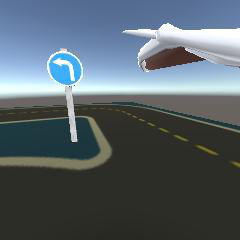




Image: 3618_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 98.38


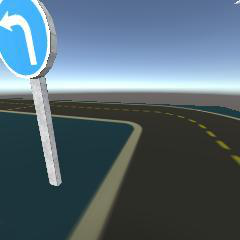




Image: 3620_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.96


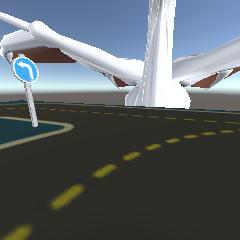




Image: peter_drive_5,962.jpg
True class:  left
Predicted class: other , with Prediction CI 79.37


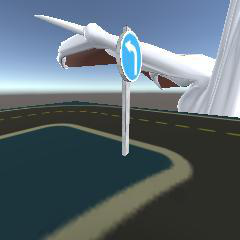




Image: 3500_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 91.1


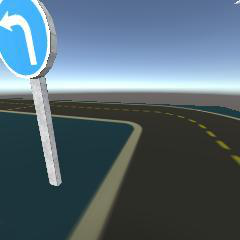




Image: 3493_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.99


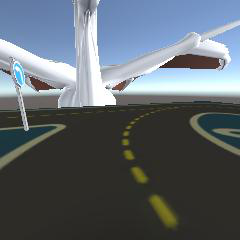




Image: 3617_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 83.95


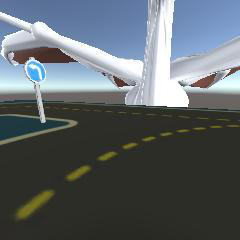




Image: 3496_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.92


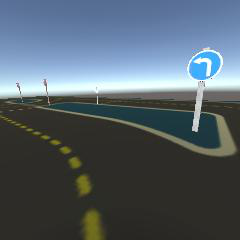




Image: 3495_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 100.0


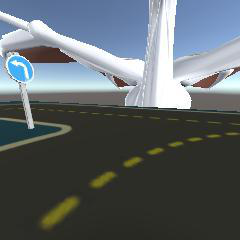




Image: 3490_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.87


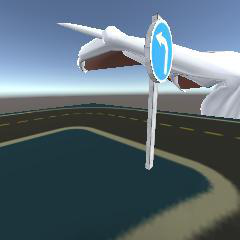




Image: 3623_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.97


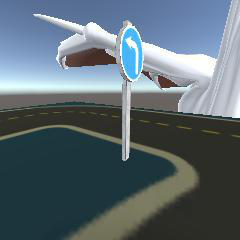




Image: peter_drive_5,968.jpg
True class:  left
Predicted class: park , with Prediction CI 55.42


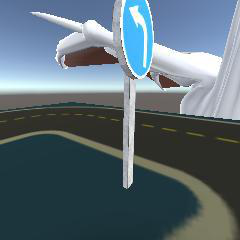




Image: 1316_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 98.27


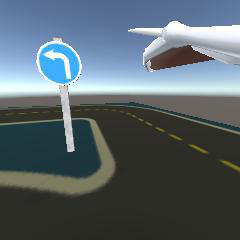




Image: 1313_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 100.0


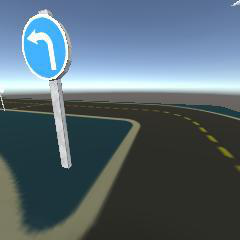




Image: 3622_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.96


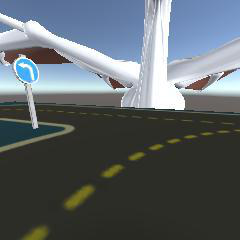




Image: 3494_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 100.0


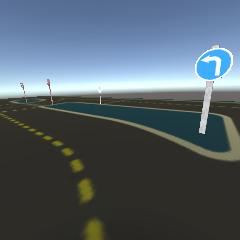




Image: 3491_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 99.99


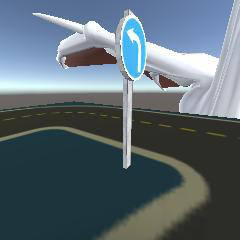




Image: 1317_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 98.27


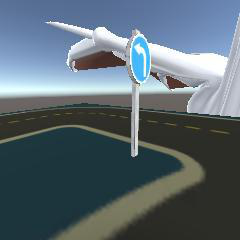




Image: 1312_cam-image_array_.jpg
True class:  left
Predicted class: other , with Prediction CI 100.0


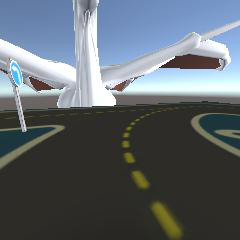

In [32]:
## Misclassification Left-turning
draw_missclassification_images('left', cnn_1, test_ds)

Image: yudan_drive_f1_652.jpg
True class:  right
Predicted class: other , with Prediction CI 88.84


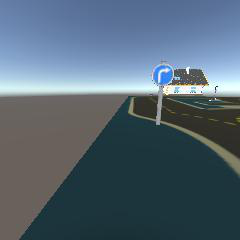




Image: yudan_drive_f1_653.jpg
True class:  right
Predicted class: other , with Prediction CI 68.41


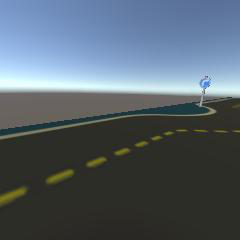




Image: yudan_drive_f1_651.jpg
True class:  right
Predicted class: other , with Prediction CI 88.84


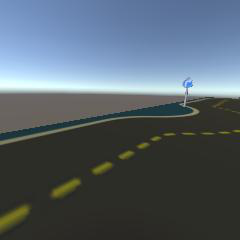




Image: yudan_drive_f1_650.jpg
True class:  right
Predicted class: other , with Prediction CI 92.38


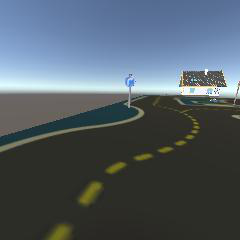




Image: yudan_drive_f1_668.jpg
True class:  right
Predicted class: other , with Prediction CI 71.76


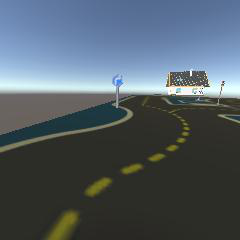




Image: yudan_drive_f1_657.jpg
True class:  right
Predicted class: other , with Prediction CI 64.61


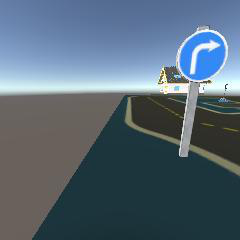




Image: yudan_drive_f1_667.jpg
True class:  right
Predicted class: other , with Prediction CI 72.22


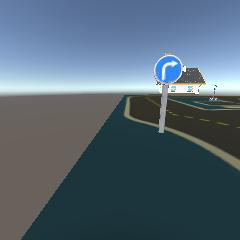




Image: yudan_drive_f1_658.jpg
True class:  right
Predicted class: other , with Prediction CI 64.61


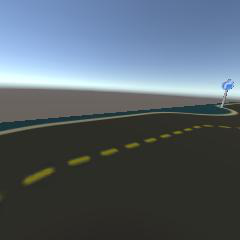




Image: yudan_drive_f1_649.jpg
True class:  right
Predicted class: other , with Prediction CI 98.07


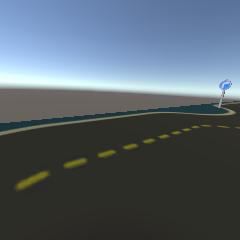

In [33]:
## Misclassification right-turning
draw_missclassification_images('right', cnn_1, test_ds)

Image: yiran_drive_Oct2_21,085.jpg
True class:  park
Predicted class: other , with Prediction CI 94.97


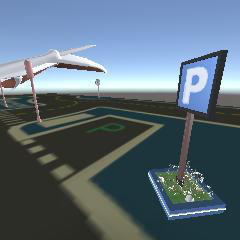




Image: yiran_drive_Oct2_21,080.jpg
True class:  park
Predicted class: other , with Prediction CI 99.52


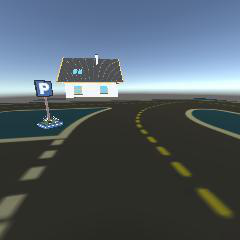




Image: 2806_cam-image_array_.jpg
True class:  park
Predicted class: stop , with Prediction CI 98.28


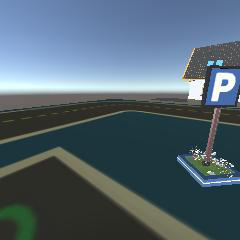




Image: 3158_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 82.01


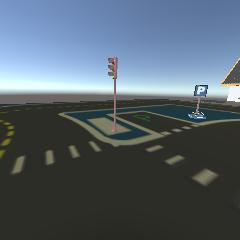




Image: 3157_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 98.09


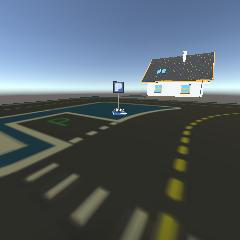




Image: 3152_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 84.14


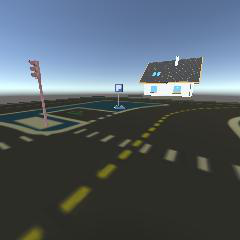




Image: yiran_drive_Oct2_21,795.jpg
True class:  park
Predicted class: other , with Prediction CI 100.0


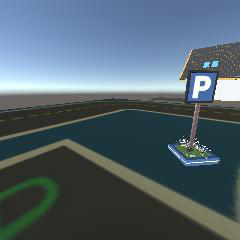




Image: 3156_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 98.09


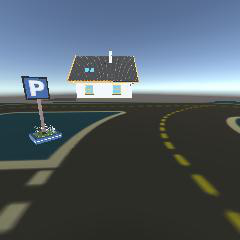




Image: 2808_cam-image_array_.jpg
True class:  park
Predicted class: stop , with Prediction CI 98.28


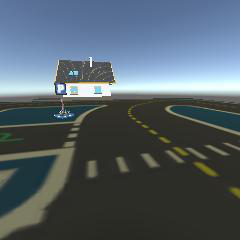




Image: 3153_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 84.14


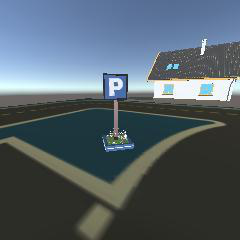




Image: 3159_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 82.01


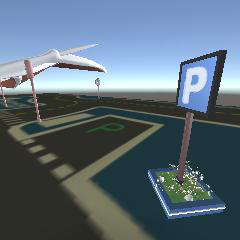




Image: 2807_cam-image_array_.jpg
True class:  park
Predicted class: stop , with Prediction CI 98.28


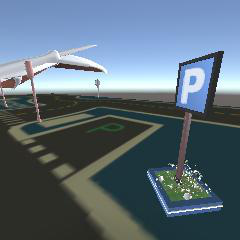




Image: 3194_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 65.0


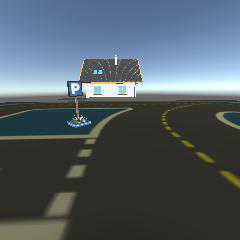




Image: 3150_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 85.41


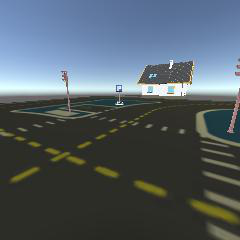




Image: peter_drive_6,064.jpg
True class:  park
Predicted class: other , with Prediction CI 63.41


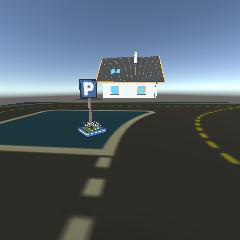




Image: 3155_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 95.08


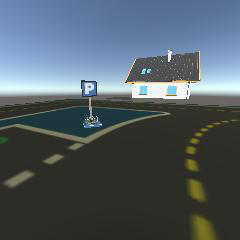




Image: 3147_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 87.97


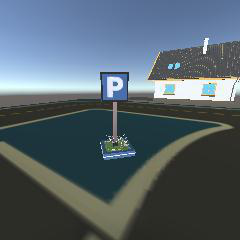




Image: peter_drive_6,061.jpg
True class:  park
Predicted class: other , with Prediction CI 99.59


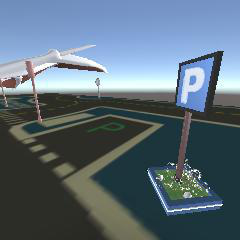




Image: peter_drive_6,060.jpg
True class:  park
Predicted class: other , with Prediction CI 98.25


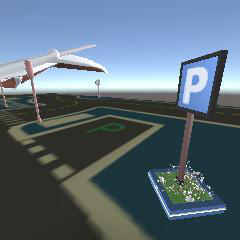




Image: peter_drive_6,062.jpg
True class:  park
Predicted class: other , with Prediction CI 95.97


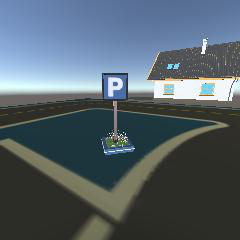




Image: peter_drive_6,063.jpg
True class:  park
Predicted class: other , with Prediction CI 67.65


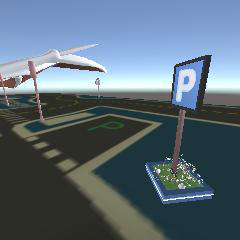




Image: 3148_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 64.37


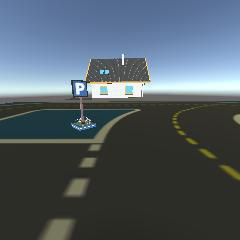




Image: 3151_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 85.41


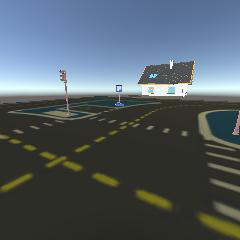




Image: 3154_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 95.08


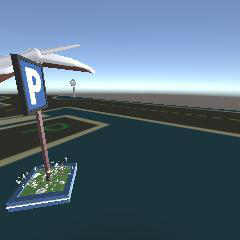




Image: 3195_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 65.0


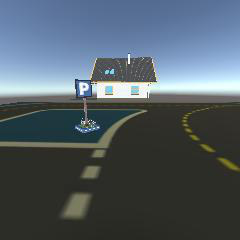




Image: 3149_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 64.37


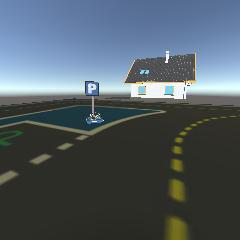




Image: 3146_cam-image_array_.jpg
True class:  park
Predicted class: other , with Prediction CI 87.97


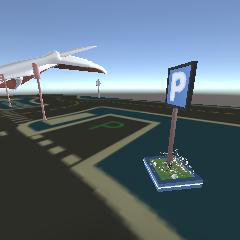

In [34]:
## Misclassification park
draw_missclassification_images('park', cnn_1, test_ds)

Image: 1991_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 81.0


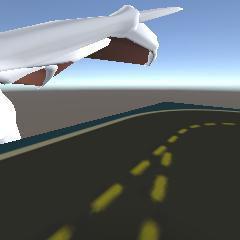




Image: 1994_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 81.63


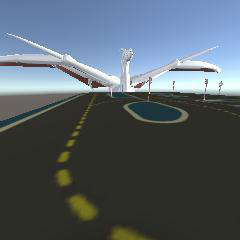




Image: yiran_drive_Oct2_1,446.jpg
True class:  other
Predicted class: park , with Prediction CI 51.28


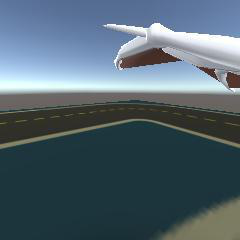




Image: 1989_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 81.89


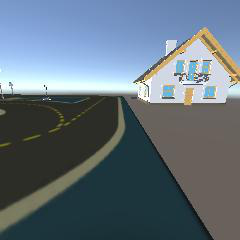




Image: 1986_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 85.02


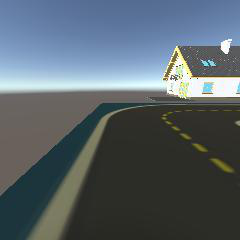




Image: 1990_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 81.0


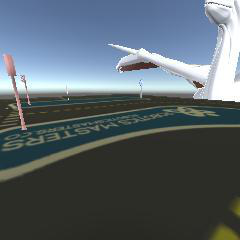




Image: 1995_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 81.63


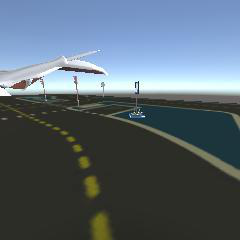




Image: 1987_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 85.02


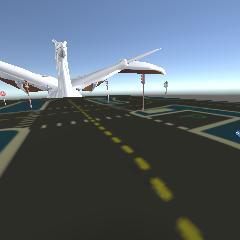




Image: 1988_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 81.89


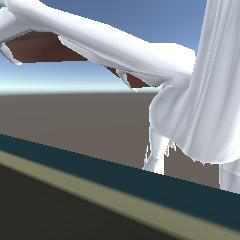




Image: 1984_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 91.95


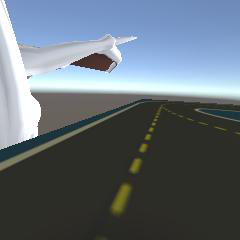




Image: 1996_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 89.64


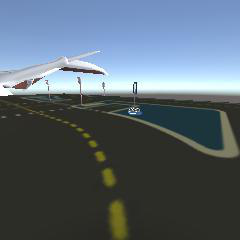




Image: 1993_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 86.98


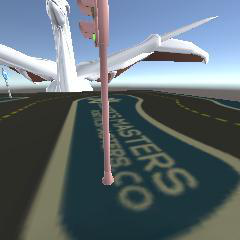




Image: 1985_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 91.95


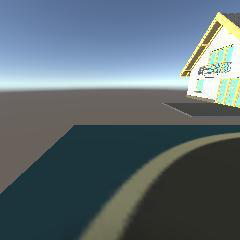




Image: 1998_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 90.01


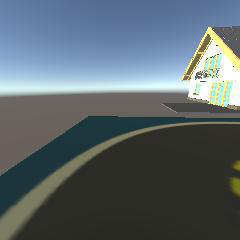




Image: 1997_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 89.64


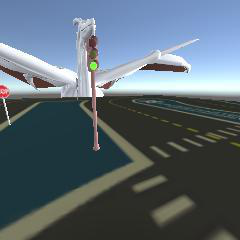




Image: 1992_cam-image_array_.jpg
True class:  other
Predicted class: left , with Prediction CI 86.98


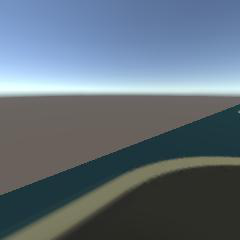

In [35]:
## Misclassification other
draw_missclassification_images('other', cnn_1, test_ds)